El siguiente código del archivo PortScan.py implementa un escaneo SYN y DNS simple con scapy.

El código accede a la capa TCP de un paquete SYN enviado y extrae el puerto de destino para compararlo con el puerto de origen del paquete recibido. Si coinciden y el paquete recibido tiene los indicadores SYN/ACK activados, el puerto se marca como abierto.

In [ ]:
from scapy.all import *
import ipaddress

ports = [25,80,53,443,445,8080,8443]

def SynScan(host):
    ans,unans = sr(
        IP(dst=host)/
        TCP(sport=33333,dport=ports,flags="S")
        ,timeout=2,verbose=0)
    print("Open ports at %s:" % host)
    for (s,r,) in ans:
        if s[TCP].dport == r[TCP].sport and r[TCP].flags=="SA":
            print(s[TCP].dport)

def DNSScan(host):
    ans,unans = sr(
        IP(dst=host)/
        UDP(dport=53)/
        DNS(rd=1,qd=DNSQR(qname="google.com"))
        ,timeout=2,verbose=0)
    if ans and ans[UDP]:
        print("DNS Server at %s"%host)
    
host = input("Enter IP Address: ")
try:
    ipaddress.ip_address(host)
except:
    print("Invalid address")
    exit(-1)

SynScan(host)
DNSScan(host)


**Ejecución:**

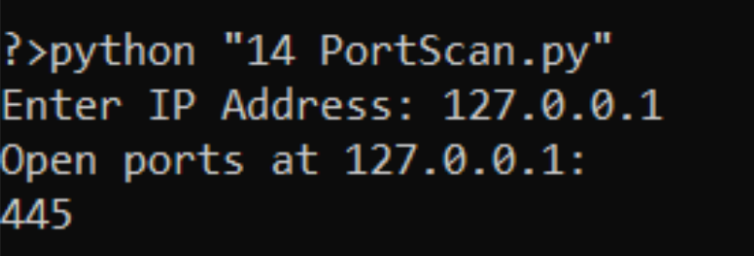

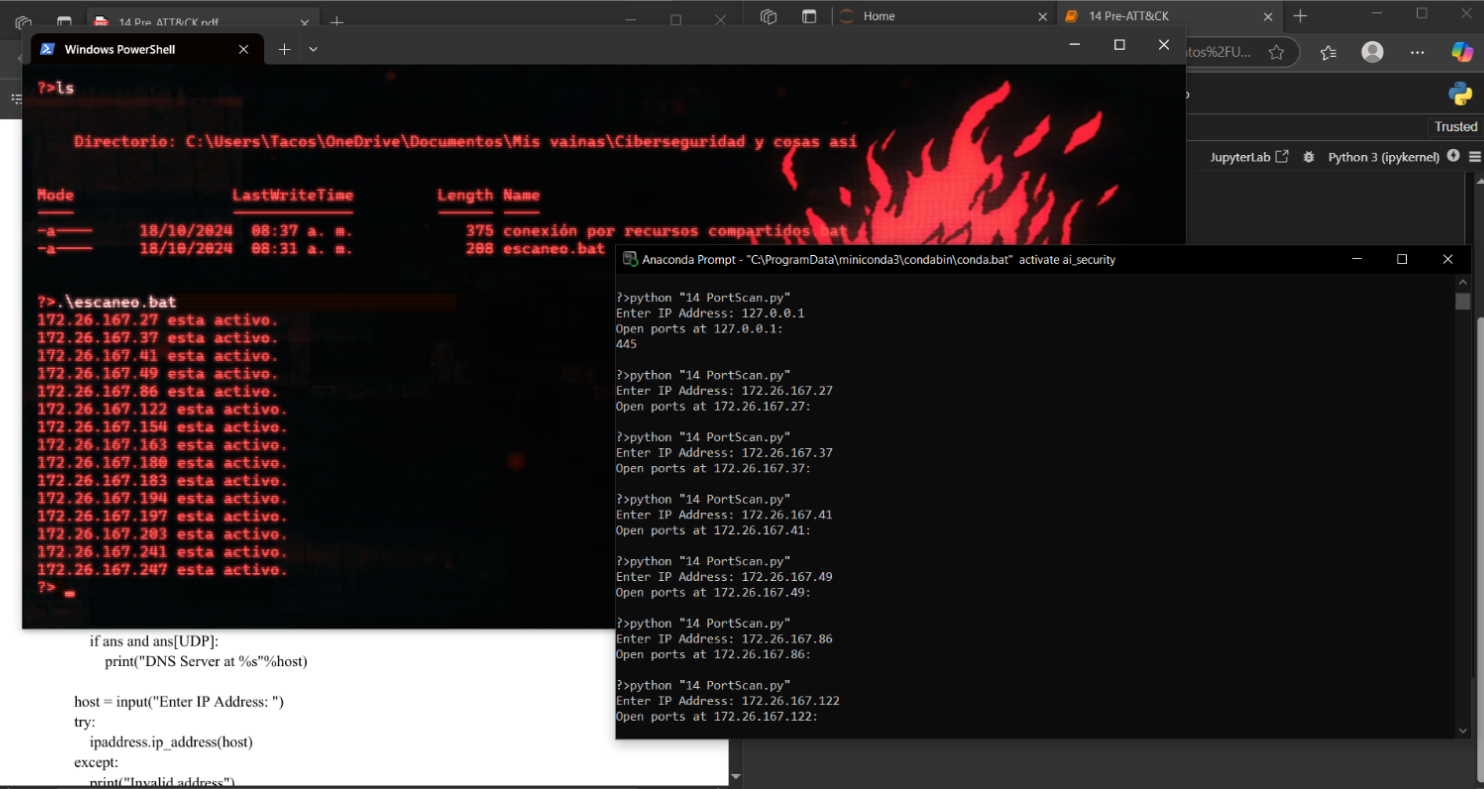

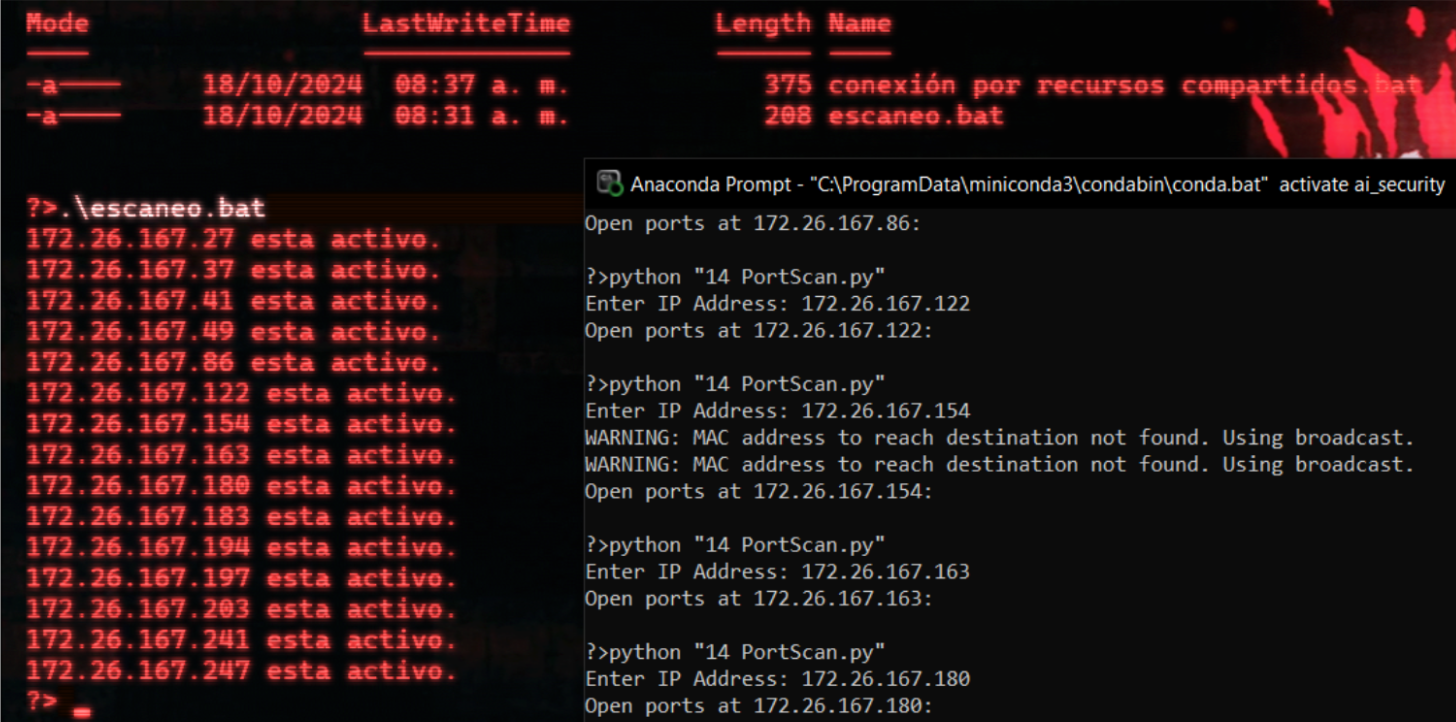

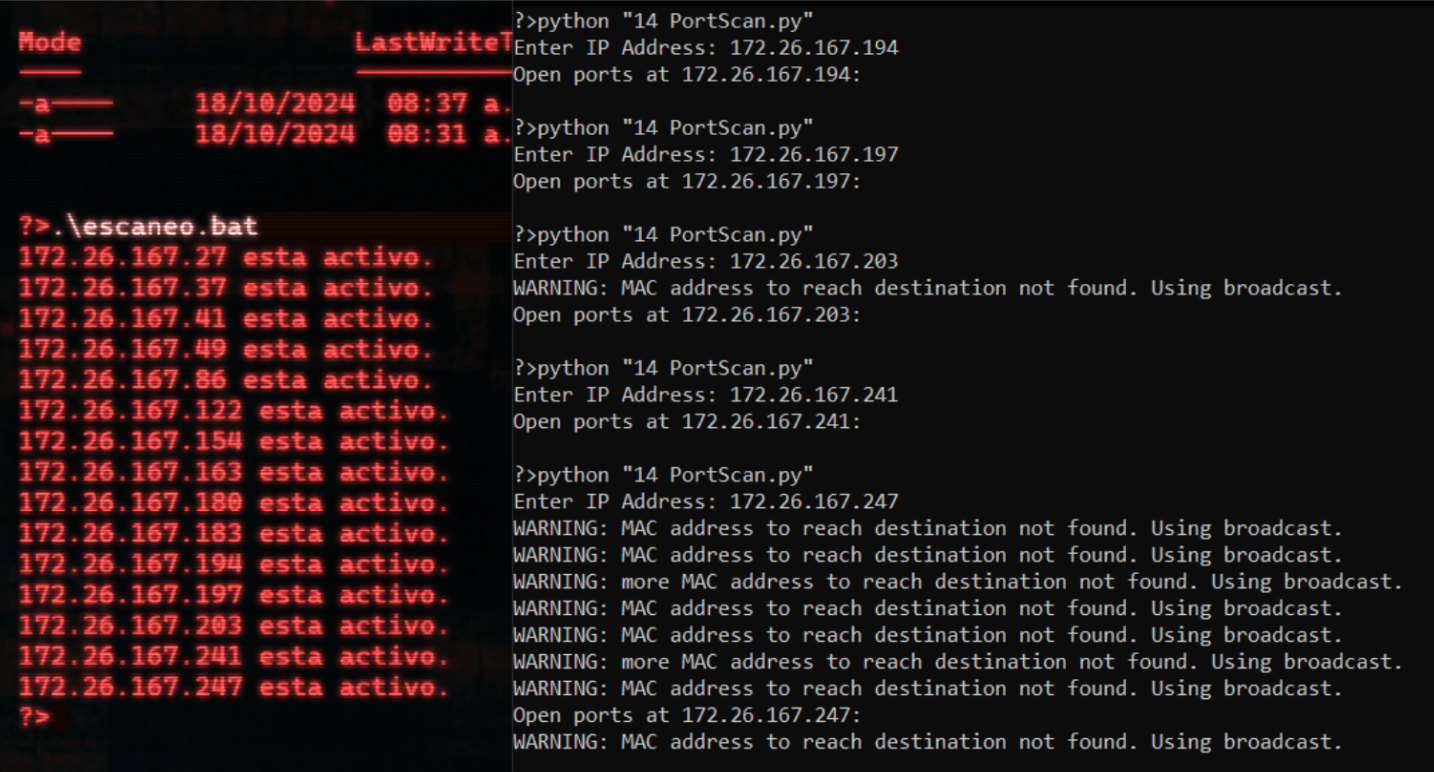

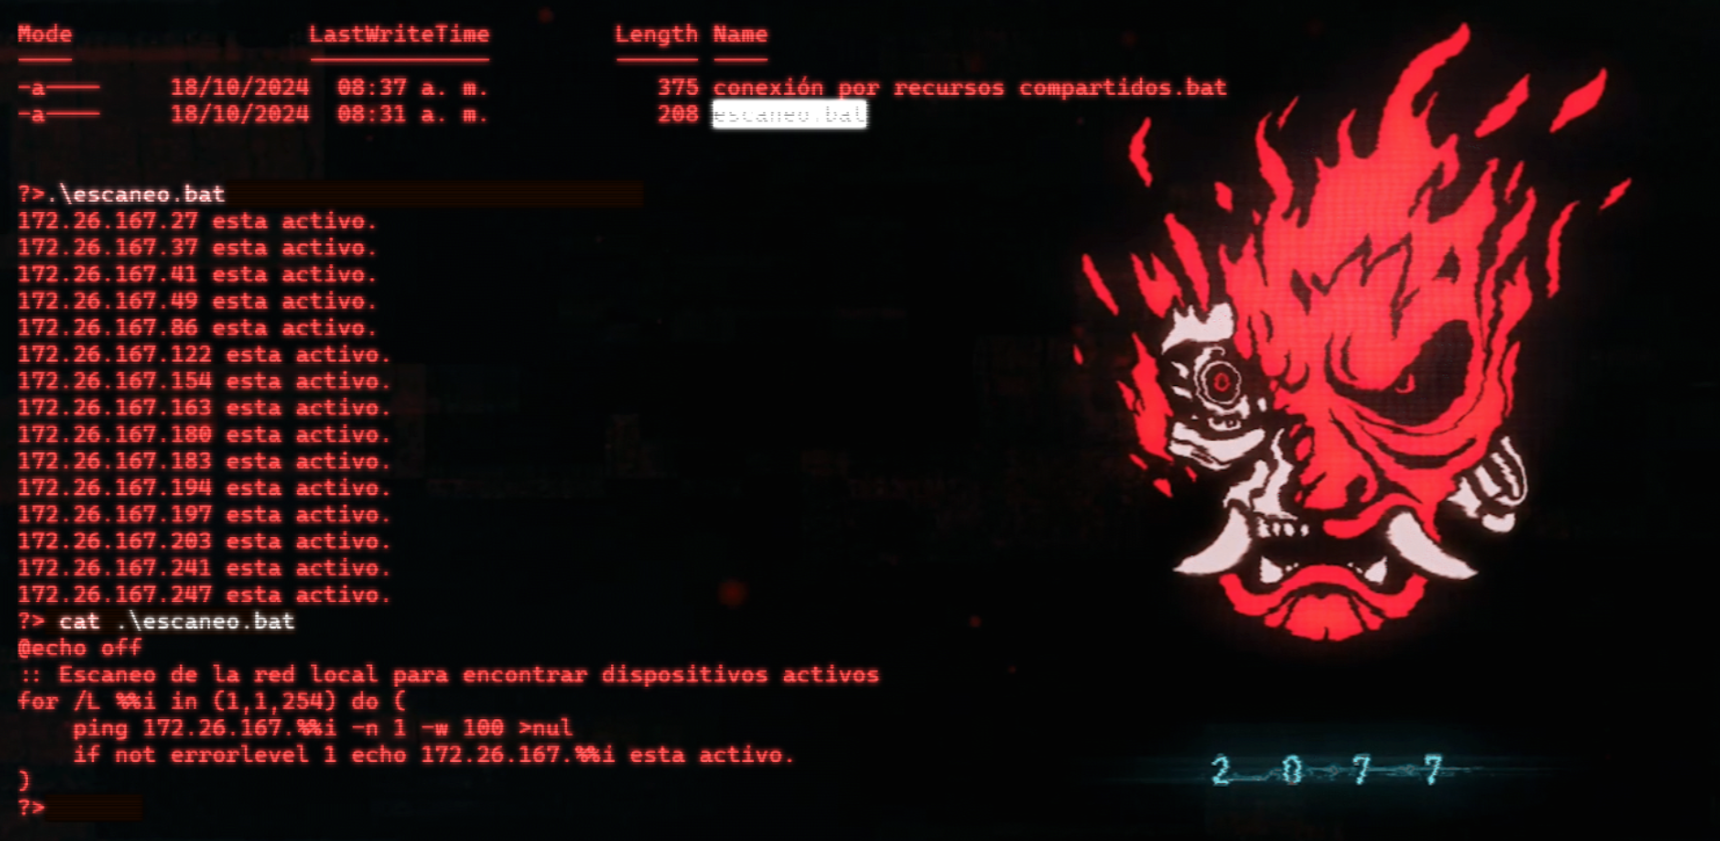

**Realización de un escaneo DNS en scapy**

La única diferencia entre implementar un escaneo SYN en scapy y un escaneo DNS radica 
en la estructura de los paquetes que envía el código. Un escaneo SYN se realiza en la capa 
TCP, mientras que una consulta DNS suele enviarse por UDP e incluye una capa DNS.


**Escaneo de red para defensores**

En este ejercicio, vemos cómo hacer que los puertos cerrados parezcan abiertos y que los puertos abiertos parezcan cerrados para un atacante. El siguiente ejemplo de código proviene del archivo HoneyScan.py:

In [ ]:
from scapy.all import *

ip = "192.168.1.209"
ports = [53,80]
honeys = [8080,8443]

blocked = []

def analyzePackets(p):
    global blocked
    if p.haslayer(IP):
        response = Ether(src=p[Ether].dst,dst=p[Ether].src)/\
            IP(src=p[IP].dst,dst=p[IP].src)/\
            TCP(sport=p[TCP].dport,dport=p[TCP].sport,ack=p[TCP].seq+1)
        source = p[IP].src
    else:
        response = Ether(src=p[Ether].dst,dst=p[Ether].src)/\
            IPv6(src=p[IPv6].dst,dst=p[IPv6].src)/\
            TCP(sport=p[TCP].dport,dport=p[TCP].sport,ack=p[TCP].seq+1)
        source = p[IPv6].src
        
    port = p[TCP].dport
    if port in honeys:
        p.show()
    if source in blocked:
        if port in ports:
            response[TCP].flags = "RA"
        elif port in honeys: 
            response[TCP].flags = "SA"
        sendp(response,verbose=False)
    else:
        if source not in ports:
            blocked += source
            if port in honeys:
                response[TCP].flags = "SA"
                sendp(response,verbose=False)

f = "dst host "+ip+" and tcp"
sniff(filter=f,prn=analyzePackets)


El objetivo de HoneyScan es anular la función SYNScan del ejemplo anterior.  Se asume que los usuarios legítimos sabrán qué puertos están ejecutando servicios (listados en puertos), por lo que cualquiera que intente conectarse a un puerto diferente es potencialmente malicioso (y aparecerá en la lista de bloqueados). En respuesta a un paquete SYN desde una dirección IP bloqueada a un puerto válido, HoneyScan enviará un paquete RST, indicando que el puerto está "cerrado".

El código también incluye una lista de puertos en honey que quiere que el atacante crea erróneamente que están abiertos. En respuesta a una solicitud a uno de estos puertos, el código enviará un paquete SYN/ACK. Esto podría usarse para confundir a un atacante, o el tráfico a estos puertos podría reenviarse a un honeypot, que podría enviar respuestas engañosas. 

En algunos casos, el sistema objetivo puede enviar una respuesta mientras HoneyScan envía otra, lo que puede crear una condición de carrera. La mejor manera de solucionar esto es ejecutar HoneyScan en un sistema que funcione en línea, como un firewall o un sistema de prevención de intrusiones (IPS). Esto permite que el sistema descarte los paquetes generados por el sistema de destino para los puertos listados en honey y los listados en ports para direcciones IP bloqueadas.

Como ya se mencionó, el objetivo de HoneyScan es generar respuestas engañosas para engañar a un escáner de puertos. Dependiendo del objetivo del escaneo (un puerto abierto válido o uno falso), los detalles de estas respuestas pueden variar; sin embargo, la estructura general de las respuestas engañosas es la misma en todo momento. Un paquete SYN/ACK o RST falso solo difiere en sus indicadores TCP.

El código prueba tres casos: 

    • Tráfico desde una fuente bloqueada a un puerto válido, lo que activa un RST/ACK. 
    • Tráfico al puerto honeypot, lo que activa un SYN/ACK. 
    • Tráfico a un puerto que no está en los puertos, lo que añade la fuente a la lista de bloqueos y también puede activar un SYN/ACK. 

Si se requiere una respuesta, los valores de los indicadores TCP se establecen mediante el valor de response[TCP].flags. El paquete se envía al cliente mediante la función sendp de scapy, que envía tráfico en la capa 2.

**Ejecución:**


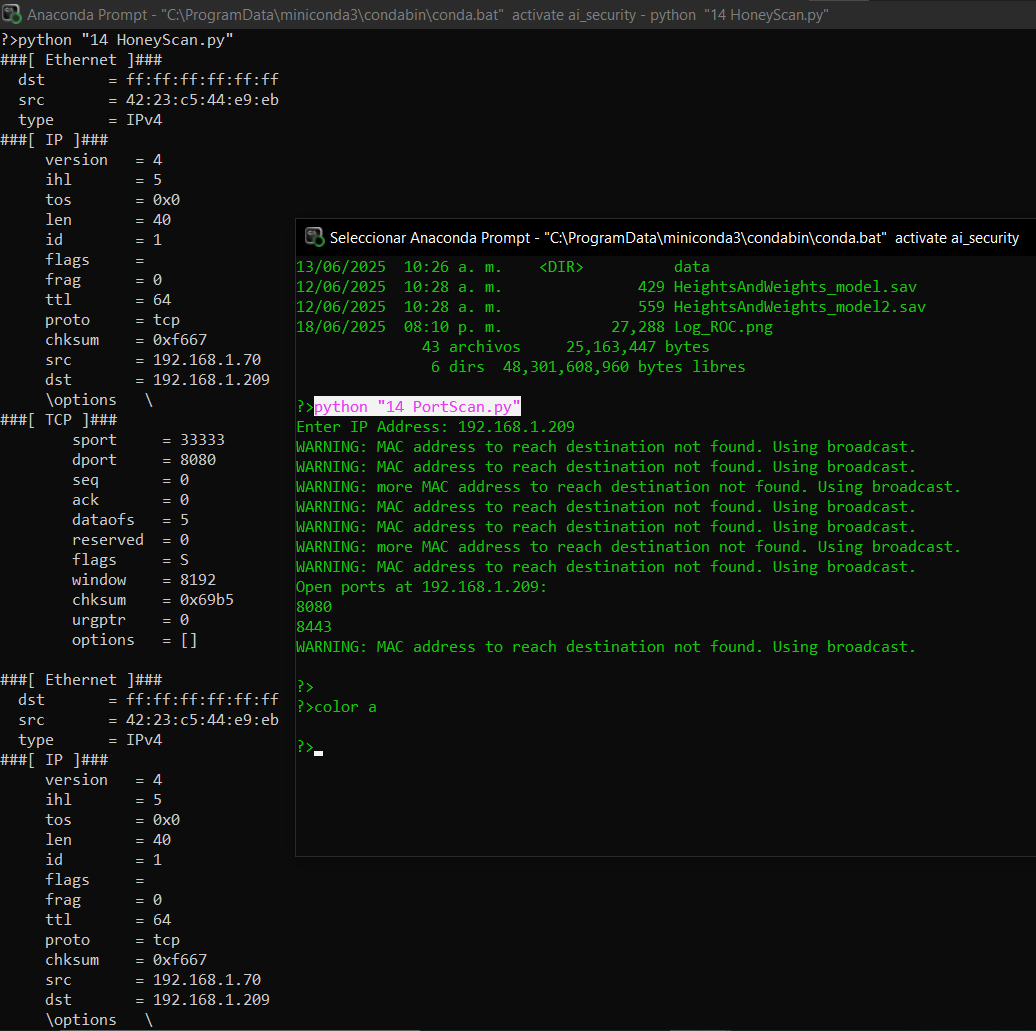 

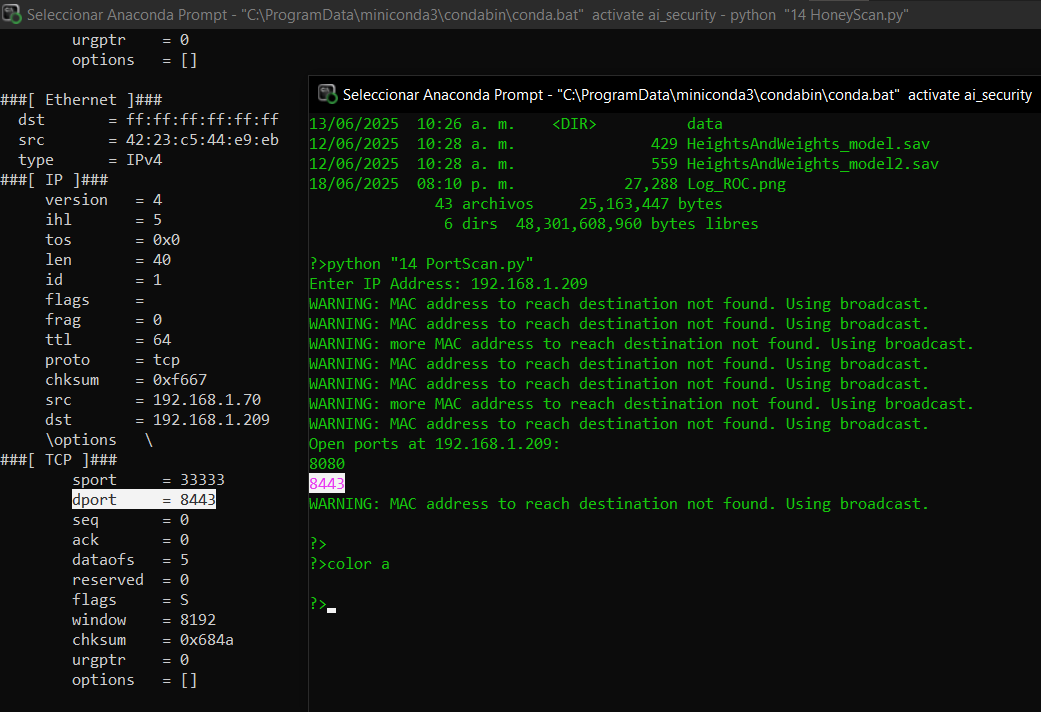

Ahora, PortScan detecta los puertos abiertos 8080 y 8443, que son los dos puertos listados en la variable honey. A partir de aquí, el defensor podría implementar un honeypot y reenviarle cualquier tráfico futuro a ese puerto. Este código de ejemplo sería más eficaz si pudiera descartar paquetes legítimos del equipo de destino. Esto se debe a que un equipo enviará un RST para un puerto cerrado y un SYN/ACK para uno abierto. 

La implementación actual de HoneyScan se esfuerza por que sus paquetes lleguen primero, lo que los convierte en la respuesta "legítima" desde la perspectiva del cliente. Implementar el filtrado de paquetes podría permitir que HoneyScan proporcione la única respuesta a las solicitudes del cliente. 

**Exploración de DNS ofensiva**

In [2]:
pip install dnspython

Note: you may need to restart the kernel to use updated packages.


In [6]:
import dns
import dns.resolver
import socket

domains = {}
subs = "C:\\Users\\Tacos\\OneDrive\\Documentos\\Universidad\\Curso - Datos, ciberseguridad e inteligencia artificial\\Actividades\\14 dns_search.txt"

res = dns.resolver.Resolver()
res.nameservers = ["8.8.8.8"]
res.port = 53

domain = "google.com"
nums = True

def ReverseDNS(ip):
    try:
        result = socket.gethostbyaddr(ip)
        return [result[0]]+result[1]
    except socket.herror:
        return []

#AQUÍ EDITÉ para intentar múltiples tipos de registros y no sólo registros A
def DNSRequest(domain):
    ips = []
    record_types = ["A", "AAAA", "CNAME"]
    for rtype in record_types:
        try:
            result = res.resolve(domain, rtype)
            addresses = [r.to_text() for r in result]
            if domain in domains:
                domains[domain] = list(set(domains[domain] + addresses))
            else:
                domains[domain] = addresses
            # Opcional: intenta resolución inversa solo para A y AAAA
            if rtype in ["A", "AAAA"]:
                for a in addresses:
                    rd = ReverseDNS(a)
                    for d in rd:
                        if d not in domains:
                            domains[d] = [a]
                            DNSRequest(d)
                        else:
                            domains[d] = [a]
        except (dns.resolver.NXDOMAIN, dns.resolver.NoAnswer, dns.exception.Timeout, dns.resolver.NoNameservers):
            continue
    return ips

def HostSearch(domain, dictionary,nums):
    successes = []
    for word in dictionary:
        d = word+"."+domain
        DNSRequest(d)
        if nums:
            for i in range(0,10):
                s = word+str(i)+"."+domain
                DNSRequest(s)

dictionary = []
with open(subs,"r") as f:
    dictionary = f.read().splitlines()
HostSearch(domain,dictionary,nums)
for domain in domains:
    print("%s: %s" % (domain, domains[domain]))


www.google.com: ['142.250.177.4', '2607:f8b0:4012:804::2004']
tzqroa-ag-in-f4.1e100.net: ['2607:f8b0:4012:821::4']
atl14s08-in-f4.1e100.net: ['142.250.177.4']
any-in-2404.1e100.net: ['216.239.36.4']
qro02s11-in-x04.1e100.net: ['2607:f8b0:4012:804::2004']
any-in-2001-4860-4802-36--4.1e100.net: ['2001:4860:4802:36::4']
qro04s04-in-x04.1e100.net: ['2607:f8b0:4012:804::2004']
www4.google.com: ['www4.l.google.com.', '192.178.52.142', '2607:f8b0:4012:81d::200e']
tzqroa-aa-in-f14.1e100.net: ['2607:f8b0:4012:81d::e']
tzqroa-aa-in-x0e.1e100.net: ['2607:f8b0:4012:81d::200e']
www5.google.com: ['www5.l.google.com.', '192.178.52.132']
tzqroa-aa-in-f4.1e100.net: ['2607:f8b0:4012:81d::4']
www6.google.com: ['gfe.core.l.google.com.', '142.251.34.4']
qro01s27-in-f4.1e100.net: ['2607:f8b0:4012:813::4']
www9.google.com: ['2607:f8b0:4012:822::200e', '192.178.56.46', 'www3.l.google.com.']
pnqroa-ab-in-f14.1e100.net: ['192.178.56.46']
pnqroa-ab-in-x0e.1e100.net: ['2607:f8b0:4012:822::200e']
mail.google.com: 

Edité el código original porque al ejecutarlo no me daba resultados interesantes. Comprobé con nslookup que se debía a que el subdominio portal.google.com existe en términos de DNS jerárquico, pero no tiene un registro tipo A (IPv4) asociado públicamente. Entonces decidí modificar el código para que pruebe con otro tipo de registros para buscar subdominios. Google puede tener otro tipos de registros, como CNAME, AAAA, o estar reservado internamente.

**Original:**
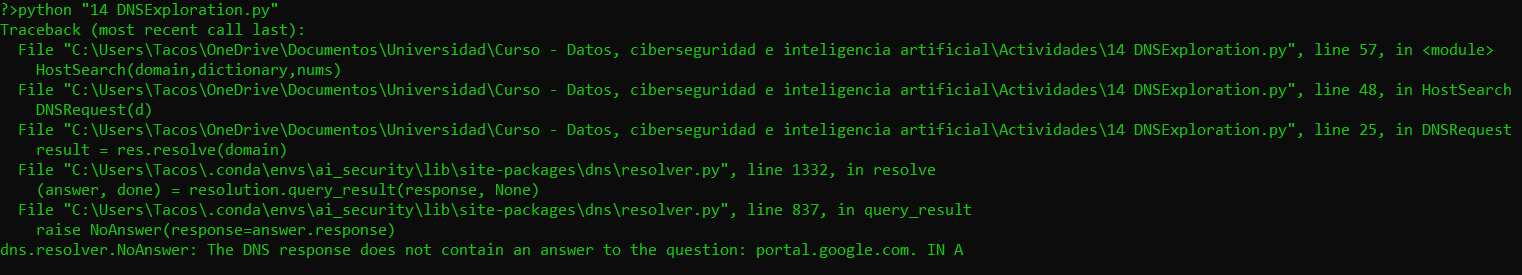

**Código modificado:**
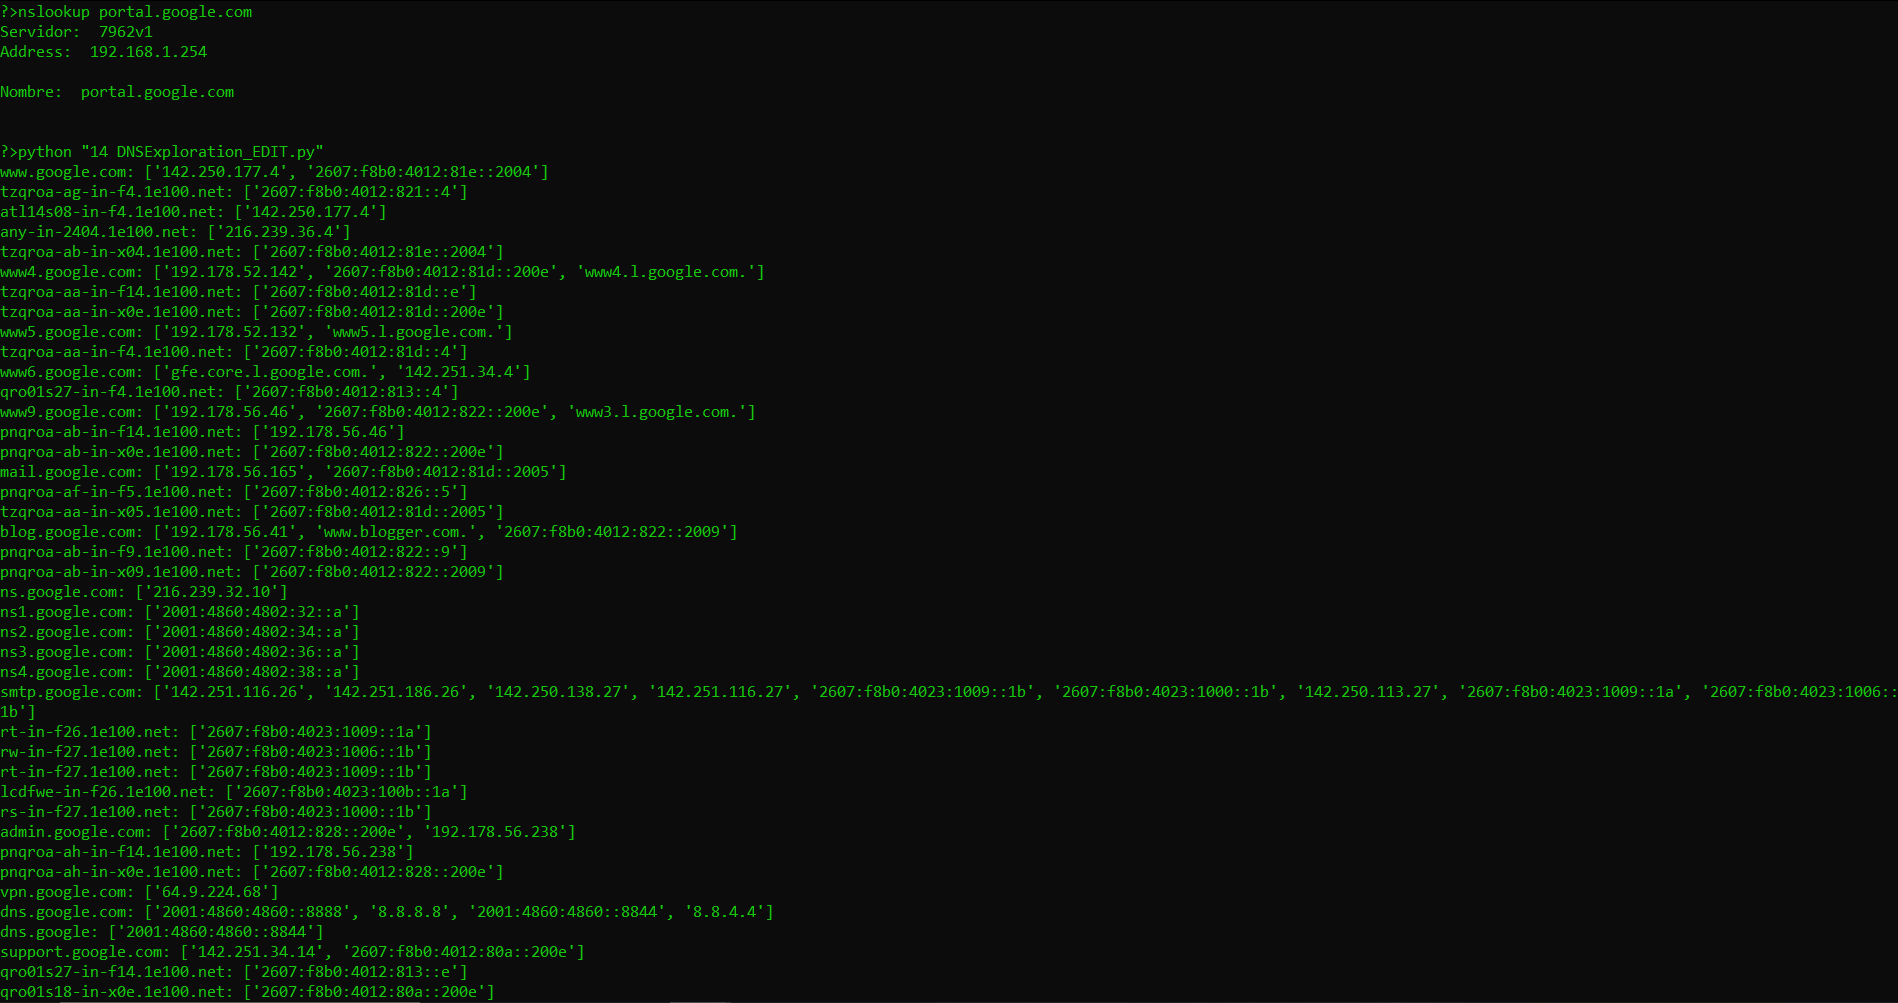

**Pruebas al dominio de la uni:**

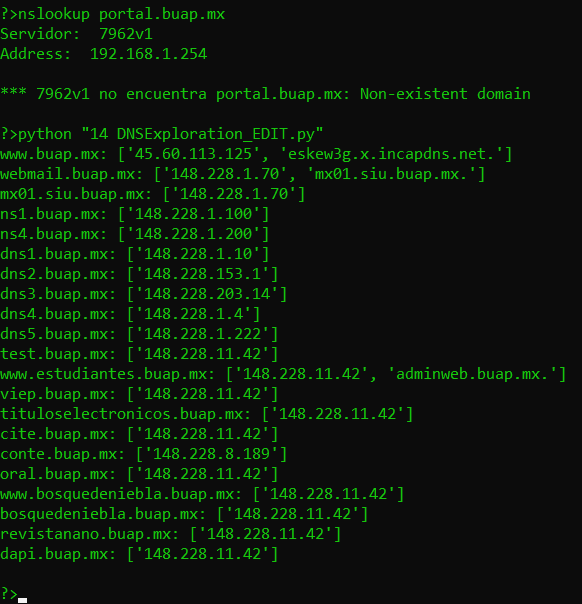

**Exploración DNS defensiva**

Las entradas DNS visibles públicamente proporcionan pistas sobre la actividad de los distintos equipos y losservicios que alojan. Una solución a este problema es no incluir información potencialmente sensible en las entradas DNS, exponiendo solo los sistemas que se desea que sean públicamente visibles. Otra opción es **usar activamente el DNS para engañar**.

El objetivo del HoneyResolver es actuar como un servidor DNS que proporciona respuestas correctas para subdominios reales, pero dirige las consultas de otros subdominios a un honeypot.

HoneyResolver utiliza dnslib de Python para implementar un servidor DNS simple. dnslib 
incluye una clase DNSServer que toma una clase Resolver y envía cualquier solicitud DNS 
a ese Resolver para su procesamiento. Tras crear el servidor, se puede iniciar con una llamada a start_thread y se ejecutará hasta que se llame a stop. En este caso, el ciclo (cuya condición de ciclo es True) ejecuta el servidor hasta que el usuario lo finaliza.

La única diferencia entre una respuesta a una solicitud de un subdominio válido y una dirigida a un honeypot es la dirección IP devuelta al cliente. En el caso de una solicitud a un dominio válido, esta dirección IP se puede buscar en los subdominios. En los dominios honeypot, se utiliza la misma dirección IP para todas las solicitudes. 

En el ejemplo anterior, usamos el servidor DNS de Google y de la BUAP para las búsquedas. Ahora, necesitamos configurar DNSExploration para usar HoneyResolver como su servidor DNS. 

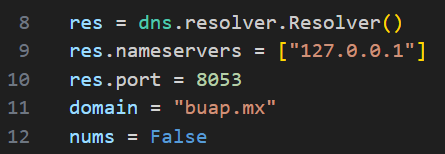

El puerto debe cambiarse al utilizado por HoneyResolver (8053). Además, el dominio debe configurarse en example.com (aunque lo dejé en buap.mx para ver que pasa 👻) y nums debe configurarse en False para deshabilitar la búsqueda de subdominios. Primero se ejecuta HoneyResolver y luego ejecuta DNSExploration en otra terminal en la misma máquina.

In [ ]:
from dnslib import *
from dnslib.server import DNSServer

host="localhost"
port = 8053

subdomains = {
    "www.": "10.0.0.1",
    "smtp.": "10.0.0.2"
}
domain = "example.com"
honeyip = "10.0.0.0"

blocked = {}

class HoneyResolver:
    def resolve(self,request,handler):
        subdomain = str(request.q.qname.stripSuffix(domain+"."))
        if subdomain in subdomains:
            reply = request.reply()
            ip = subdomains[subdomain]
            reply.add_answer(RR(
                rname=request.q.qname,
                rtype=QTYPE.A,
                rclass=1,
                ttl=300,
                rdata=A(ip)))
        else:
            reply = request.reply()
            reply.add_answer(RR(
                rname=request.q.qname,
                rtype=QTYPE.A,
                rclass=1,
                ttl=300,
                rdata=A(honeyip)))
        return reply

resolver = HoneyResolver()
server = DNSServer(resolver,port=port,address=host)
server.start_thread()
while True:
    time.sleep(5)
server.stop()

**Resultados:**

Como se puede observar en la terminal del atacante (letras verdes), la diferencia antes y después de ejecutar el HoneyResolver es clara. No hizo falta usar un dominio ficticio (www.example.com) para poder ver lo eficaz que resulta el HoneyResolver. Pero considero que hay un detalle interesante e inesperado del que hablar, **la búsqueda de subdominios fue más exhaustiva**, esto es contraintuitivo ya que asignamos a *nums* el valor False para desactivar la búsqueda de subdominios. Mi hipótesis es que este resultado inesperado es una consecuencia de que HoneyResolver hace una "protección exhaustiva" de todos los subdominios posibles a ser atacados. Infiero esto debido a que si observamos la terminal del defensor (letras blancas) notaremos que incluso hay más subdominios que los que "descubrió" la terminal del atacante. Si bien el objetivo final del defensor fue exitoso (mostrar una misma IP para todos los subdominios) creo que hay un margen de mejora, pues sin querer le dimos más información al atacante de la que pudo obtener si no se ejecutaba el HoneyResolver (parcialmente). Esto pone de manifiesto que las soluciones de seguridad deben probarse previo a su implementación y que requieren un esfuerzo continuo de refinamiento.

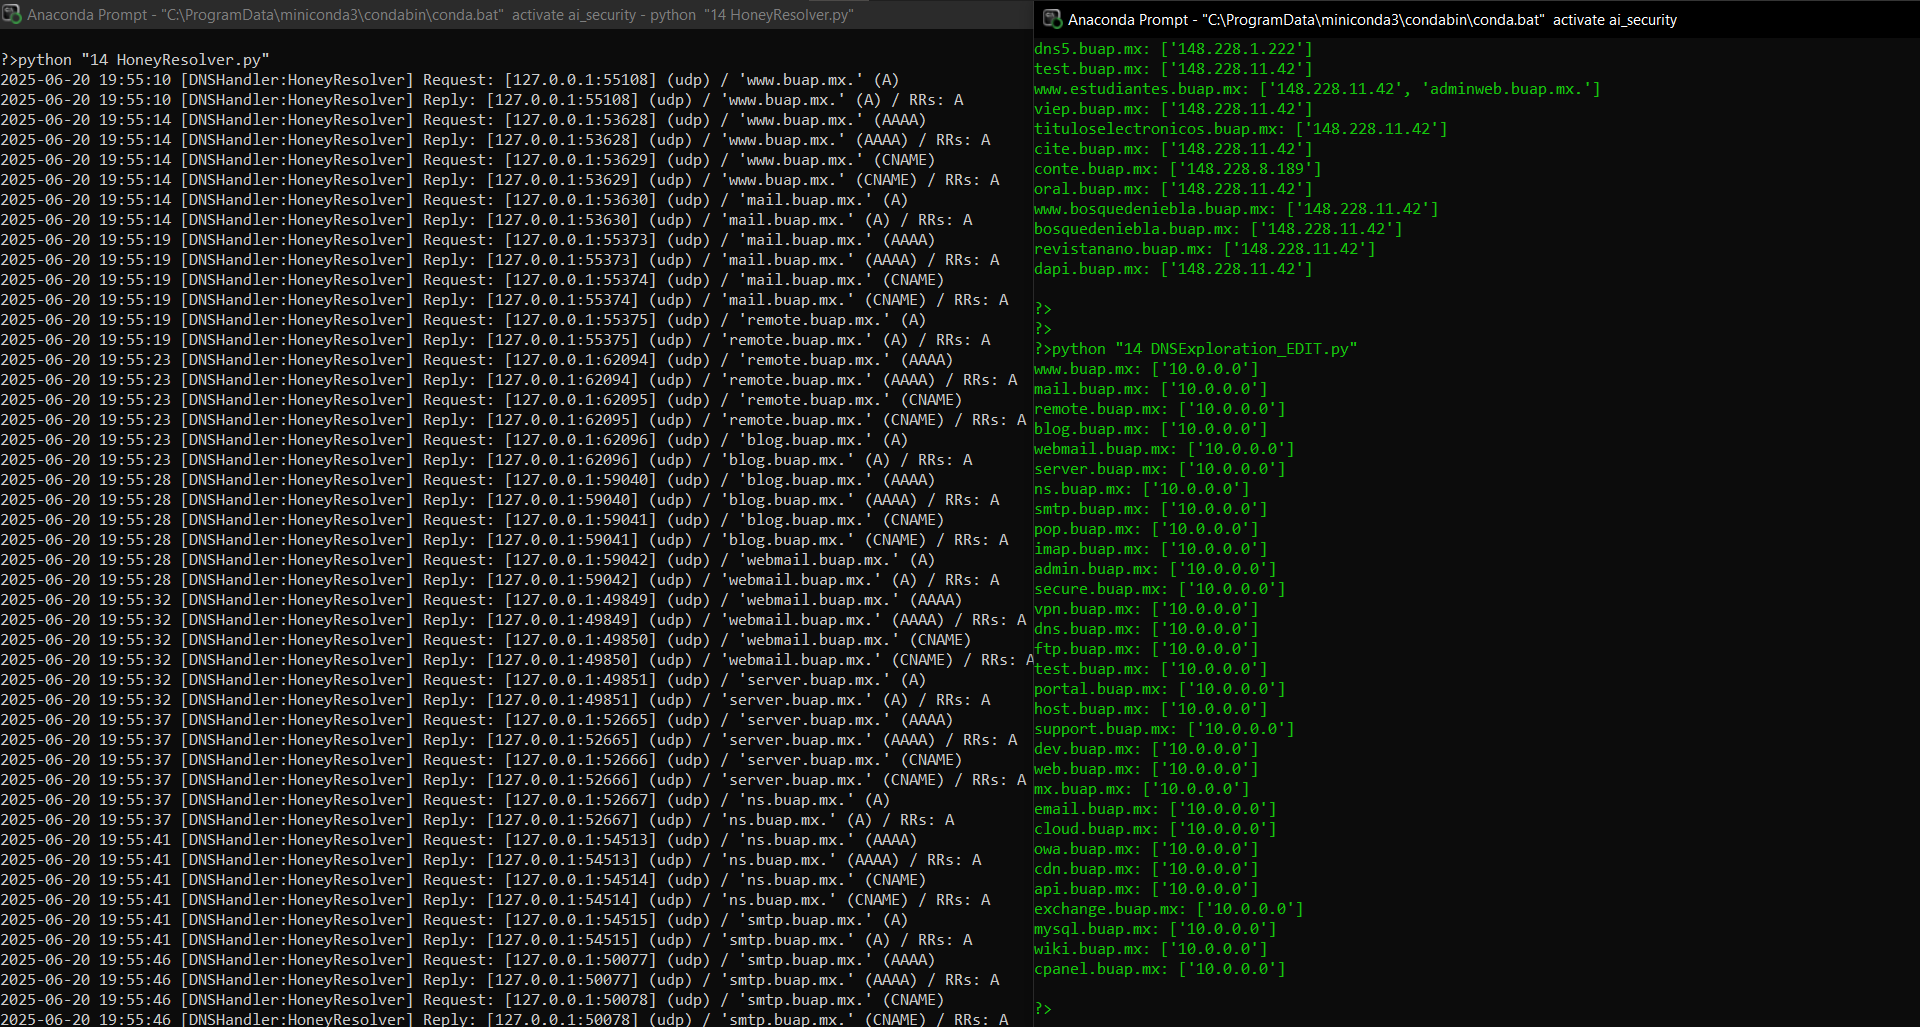

Antes vs después de HoneyResolver:

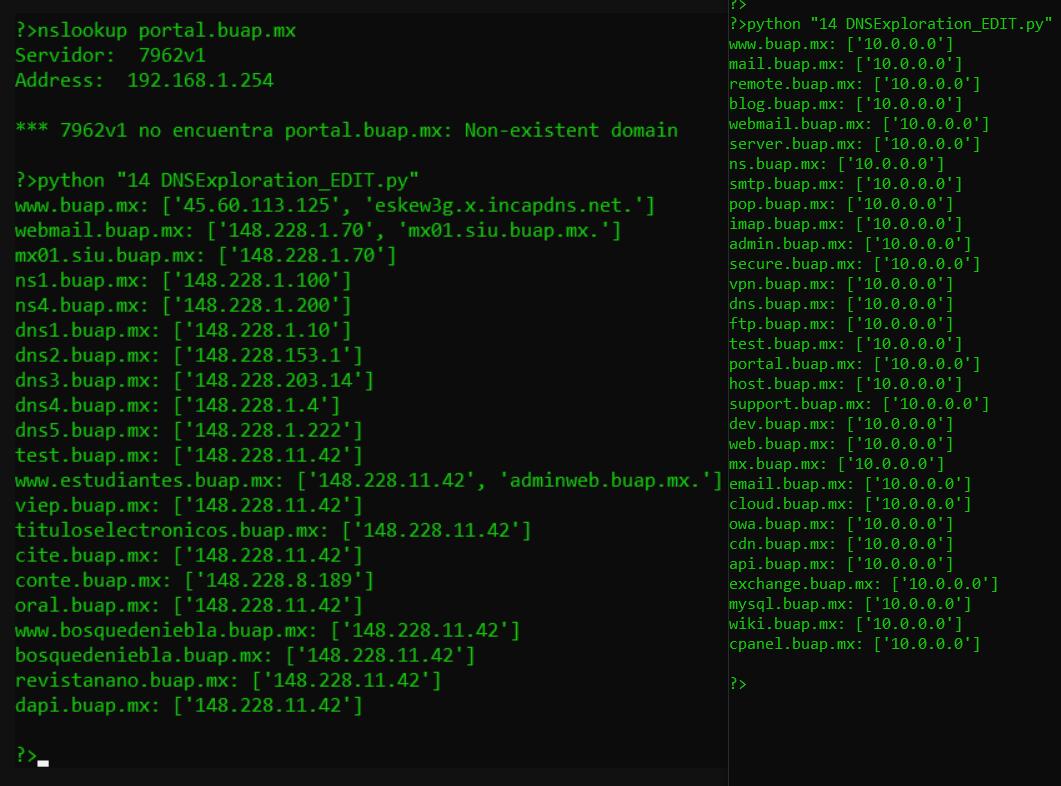

Terminal del defensor pt. 1:

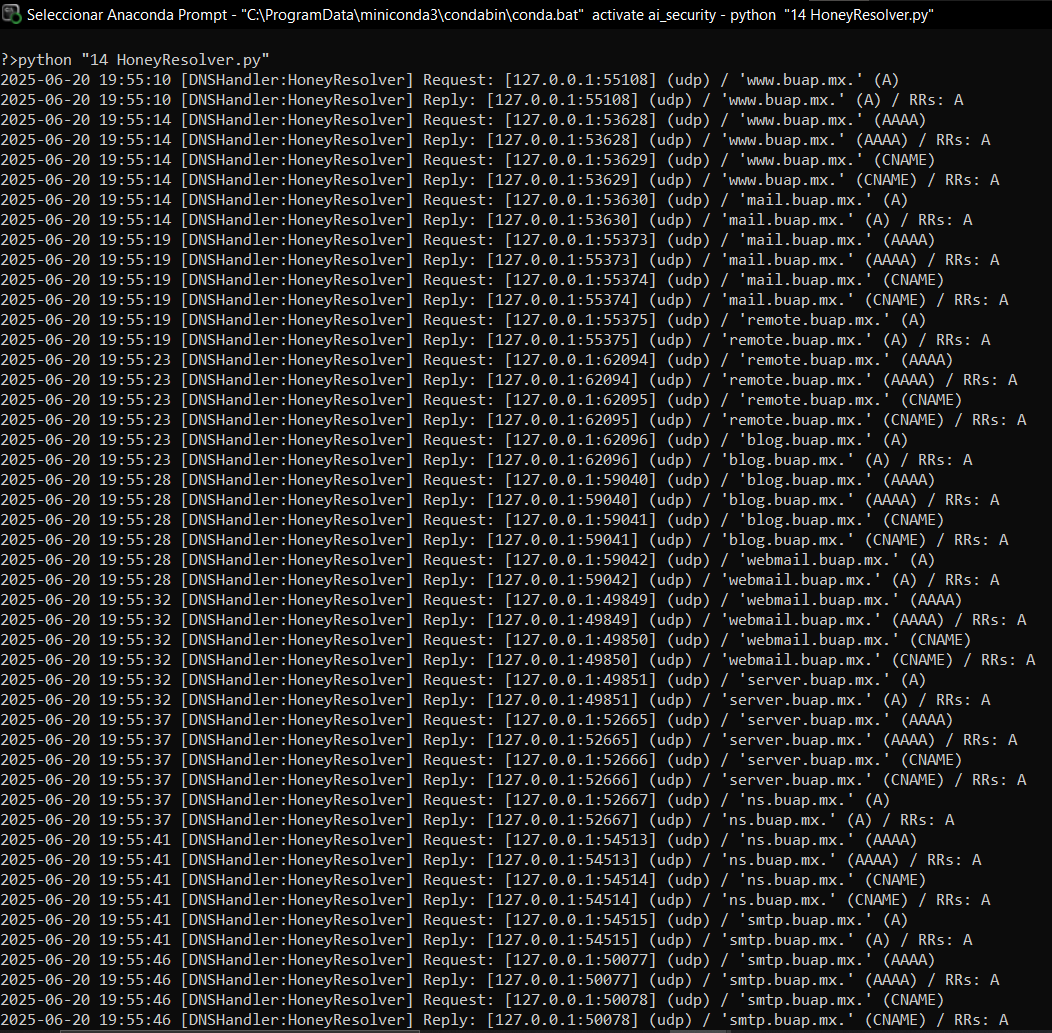

Terminal del defensor pt. 2:

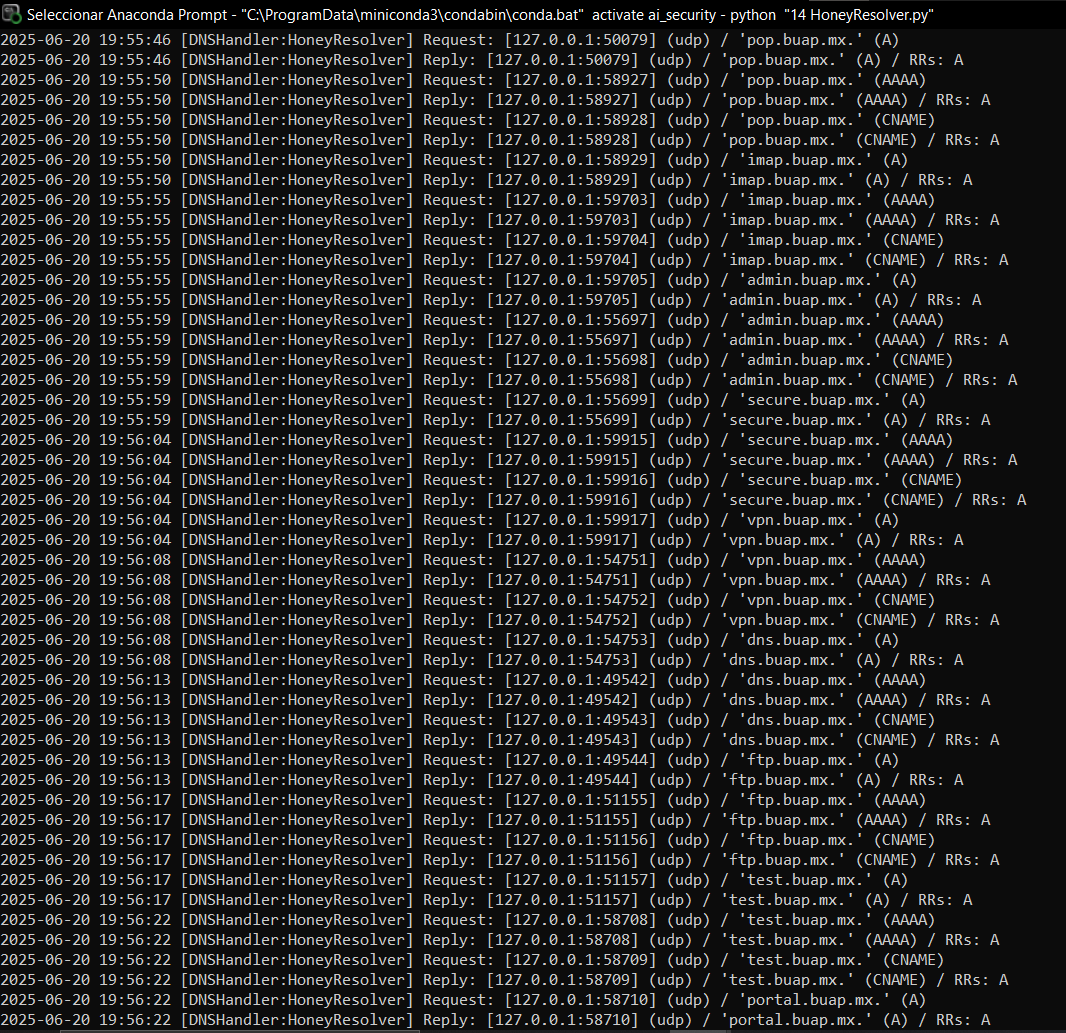

Terminal del defensor pt. 3:

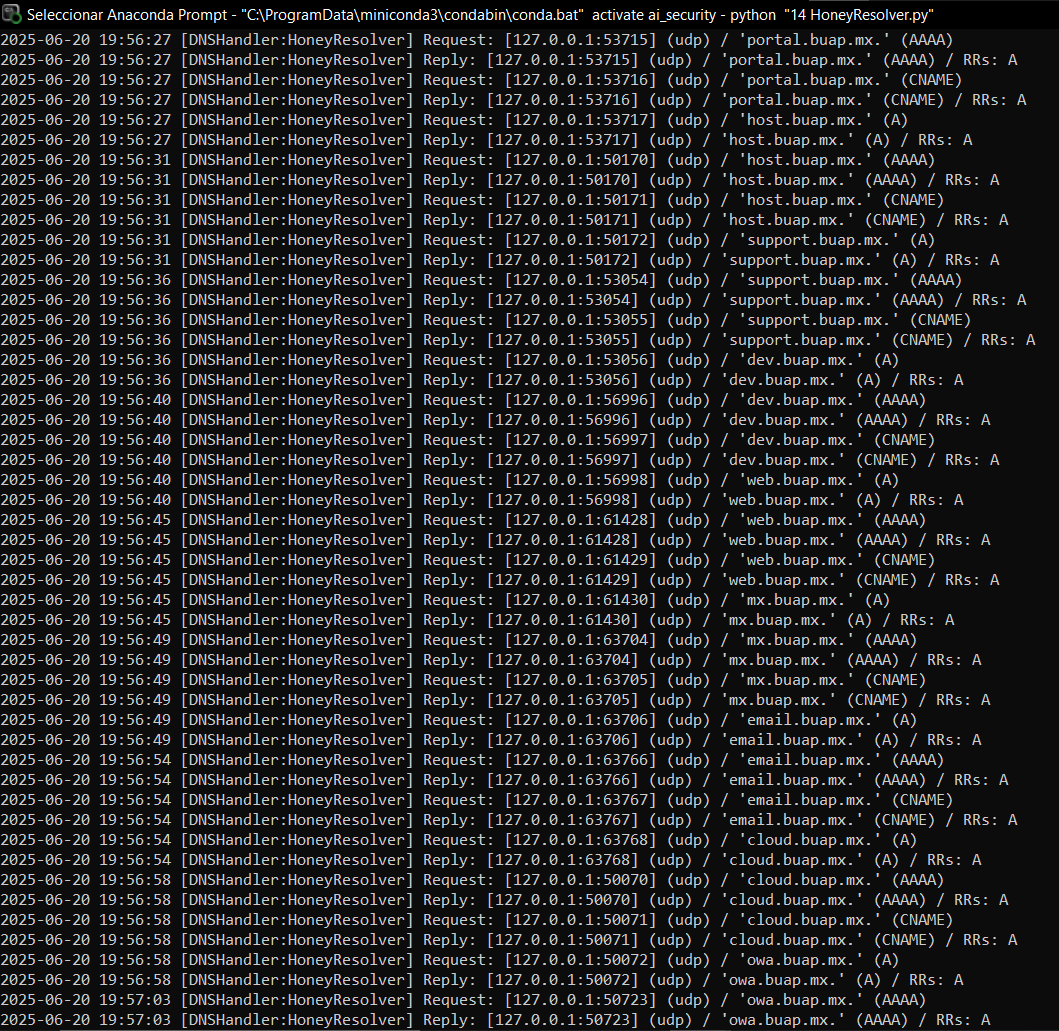

Terminal del defensor pt. 4:

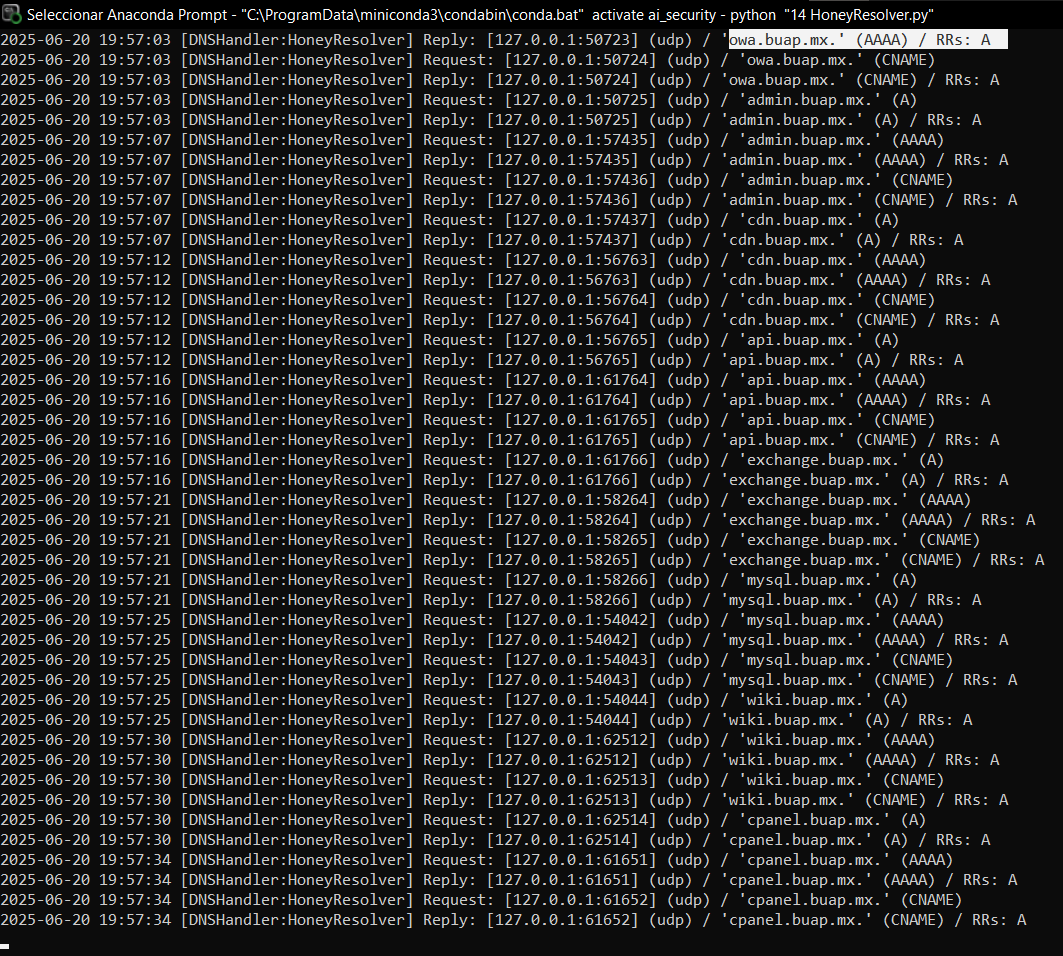